In [1]:
#import psycopg
import pandas as pd
from typing import List,Tuple,Dict
import re
from pathlib import Path

In [19]:
timings = list(x.read_text() for x in Path("/home/jovyan").glob("timings_*.txt"))
timings

["timing on\nCOPY customer\nFROM '/etc/data/customer.tbl' WITH DELIMITER AS '|';\nTime: 20057.995 ms (00:20.058)\nCOPY lineitem\nFROM '/etc/data/lineitem.tbl' WITH DELIMITER AS '|';\nTime: 927397.782 ms (15:27.398)\nCOPY nation\nFROM '/etc/data/nation.tbl' WITH DELIMITER AS '|';\nTime: 5.412 ms\nCOPY orders\nFROM '/etc/data/orders.tbl' WITH DELIMITER AS '|';\nTime: 187279.696 ms (03:07.280)\nCOPY part\nFROM '/etc/data/part.tbl' WITH DELIMITER AS '|';\nTime: 25851.882 ms (00:25.852)\nCOPY partsupp\nFROM '/etc/data/partsupp.tbl' WITH DELIMITER AS '|';\nTime: 112783.973 ms (01:52.784)\nCOPY region\nFROM '/etc/data/region.tbl' WITH DELIMITER AS '|';\nTime: 5.744 ms\nCOPY supplier\nFROM '/etc/data/supplier.tbl' WITH DELIMITER AS '|';\nTime: 1067.511 ms (00:01.068)\nALTER TABLE REGION\nADD PRIMARY KEY (R_REGIONKEY);\nTime: 9.779 ms\nALTER TABLE NATION\nADD PRIMARY KEY (N_NATIONKEY);\nTime: 1.998 ms\nALTER TABLE CUSTOMER\nADD PRIMARY KEY (C_CUSTKEY);\nTime: 6857.001 ms (00:06.857)\nALTER TABL

In [137]:
def extract_all_info(payload : str):
    load_speeds_table = re.findall("COPY (\w+)",payload)
    pk_speeds_table = list(map(str.lower,re.findall("ALTER TABLE ([A-Z]+)",payload)))
    fk_speeds_table = list(map(str.lower,re.findall("ADD FOREIGN KEY \([^\)]+\) REFERENCES ([^\(]+)",payload)))
    time = list(map(lambda x:float(x)/1000,re.findall("Time: (\d+\.\d+) ms",payload)))

    copy_speeds = zip(load_speeds_table,time)
    time = time[len(load_speeds_table):]
    
    fk_speeds = zip(fk_speeds_table,time[-len(fk_speeds_table):])
    time = time[:-len(fk_speeds_table)]

    pk_speeds = zip(pk_speeds_table,time)

    return copy_speeds,pk_speeds,fk_speeds


copy_speeds,pk_speeds,fk_speeds = list(map(list,extract_all_info(timings[0])))
copy_speeds,pk_speeds,fk_speeds

([('customer', 20.057995),
  ('lineitem', 927.397782),
  ('nation', 0.005412),
  ('orders', 187.279696),
  ('part', 25.851882),
  ('partsupp', 112.783973),
  ('region', 0.005744),
  ('supplier', 1.0675109999999999)],
 [('region', 0.009779),
  ('nation', 0.001998),
  ('customer', 6.857001),
  ('supplier', 0.169716),
  ('part', 10.478716),
  ('partsupp', 51.993078000000004),
  ('orders', 83.01826799999999),
  ('lineitem', 391.021086)],
 [('region', 0.020415),
  ('nation', 0.19600700000000001),
  ('nation', 3.909229),
  ('supplier', 26.550603),
  ('part', 33.990935),
  ('customer', 70.113177),
  ('orders', 239.316032),
  ('partsupp', 302.71952600000003)])

In [138]:
copy_speeds,pk_speeds,fk_speeds = list(),list(),list()

for payload in timings:
    a,b,c = extract_all_info(payload)
    copy_speeds += (a)
    pk_speeds += (b)
    fk_speeds += (c)

In [139]:
df_loading_speeds =  pd.DataFrame(copy_speeds, columns=['Table', 'Time'])
df_loading_speeds["Size (MB)"] = df_loading_speeds["Table"].map(
    lambda x: Path(f"/home/jovyan/work/data-management/data/{x}.tbl").stat().st_size / 2**20
)
df_loading_speeds["Throughput (MB/s)"] = (df_loading_speeds["Size (MB)"] / df_loading_speeds["Time"])
df_loading_speeds

,Table,Time,Size (MB),Throughput (MB/s)
0,customer,20.057995,1164.568898,58.060085
1,lineitem,927.397782,37415.176579,40.344259
2,nation,0.005412,0.002097,0.387496
3,orders,187.279696,8370.520937,44.695293
4,part,25.851882,1154.949098,44.675629
5,partsupp,112.783973,5758.113655,51.054361
6,region,0.005744,0.000366,0.063755
7,supplier,1.067511,67.588634,63.314228
8,customer,20.738715,1164.568898,56.154342
9,lineitem,897.060608,37415.176579,41.708638


<Axes: title={'center': 'Time to load each table'}, xlabel='Table', ylabel='Time in seconds'>

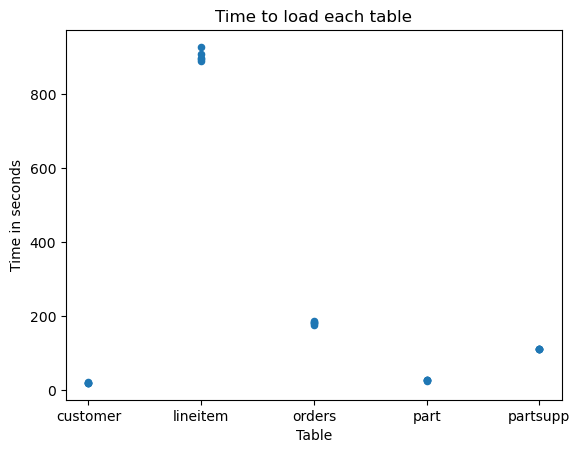

In [140]:
df_loading_speeds.query("`Size (MB)` > 2**10").plot(
    kind="scatter",title="Time to load each table",x="Table",y="Time",ylabel="Time in seconds"
)

<Axes: title={'center': 'Time to create the primary key for each tabel'}, xlabel='Table', ylabel='Time in seconds'>

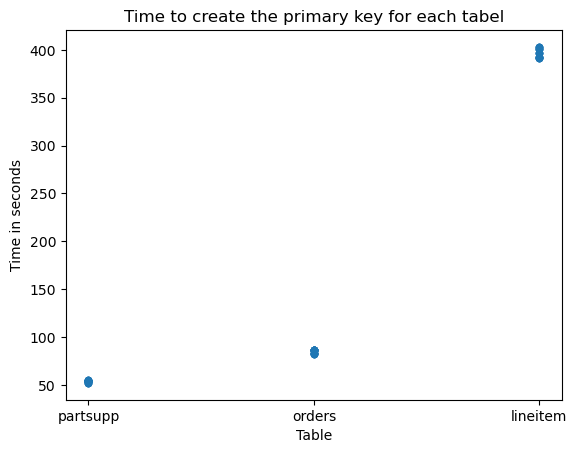

In [141]:
df_pk_speed = pd.DataFrame(pk_speeds,columns="Table Time".split(" "))
df_pk_speed.merge(df_loading_speeds.query(f"`Size (MB)` > {5 * 2**10}")["Table"],on="Table").plot(
    kind="scatter",title="Time to create the primary key for each tabel",x="Table",y="Time",ylabel="Time in seconds"
)

<Axes: title={'center': 'Time to create the foreign key for each tabel'}, xlabel='Table', ylabel='Time in seconds'>

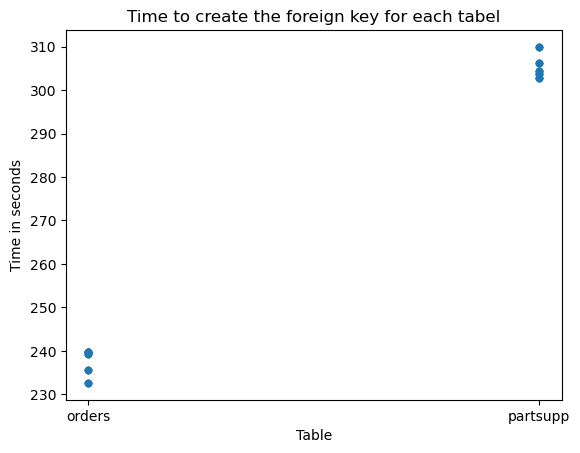

In [142]:
df_fk_speed = pd.DataFrame(fk_speeds,columns="Table Time".split(" "))
df_fk_speed.merge(df_loading_speeds.query(f"`Size (MB)` > {5 * 2**10}")["Table"],on="Table").plot(
    kind="scatter",title="Time to create the foreign key for each tabel",x="Table",y="Time",ylabel="Time in seconds"
)

In [143]:
df_loading_speeds.groupby("Table")["Throughput (MB/s)"].describe().sort_values("mean",ascending=False)[["mean","std","min","max"]]

,mean,std,min,max
Table,,,,
supplier,62.961091,1.492105,60.379449,64.250622
customer,55.805687,3.272780,50.117549,58.060085
partsupp,51.796811,0.429470,51.054361,52.099253
orders,45.949668,1.070430,44.695293,47.588606
part,42.625060,1.337928,40.973884,44.675629
lineitem,41.439145,0.690757,40.344259,42.115341
nation,0.464144,0.084825,0.387496,0.569099
region,0.093284,0.021603,0.063755,0.121544


In [77]:
timings = list(Path("/home/jovyan/query-results/").glob("*.txt"))

# import re

# def natural_sort(l): 
#     convert = lambda text: int(text) if text.isdigit() else text.lower()
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key.stem)]
#     return sorted(l, key=alphanum_key)

# timings = natural_sort(timings)
timings = list((x.stem,x.read_text()) for x in timings)
timings[:2]


[('timings-query_1-1',
  "timing on\nTiming is on.\nselect\nl_returnflag,\nl_linestatus,\nsum(l_quantity) as sum_qty,\nsum(l_extendedprice) as sum_base_price,\nsum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty,\navg(l_extendedprice) as avg_price,\navg(l_discount) as avg_disc,\ncount(*) as count_order\nfrom lineitem\nwhere\nl_shipdate <= date '1998-12-01' - interval '108' day\ngroup by l_returnflag, l_linestatus\norder by l_returnflag, l_linestatus;\n l_returnflag | l_linestatus |    sum_qty    |  sum_base_price  |   sum_disc_price   |      sum_charge      |       avg_qty       |     avg_price      |        avg_disc        | count_order \n--------------+--------------+---------------+------------------+--------------------+----------------------+---------------------+--------------------+------------------------+-------------\n A            | F            | 1887655913.00 | 2830563886

In [78]:
import collections
query_times = collections.defaultdict(list)

In [88]:
for name,text in reversed(timings):
    time = re.search("Time: (\d+\.\d+) ms",text).group(1)
    sample = re.search("timings-query_\d+-(\d+)",name).group(1)
    query_times[str(sample)].append(float(time)/1000)

In [87]:
df_queries = pd.DataFrame.from_dict(query_times).describe().transpose()[["mean","std","min","max"]].sort_values("mean",ascending=False)
df_queries

,mean,std,min,max
21,924.600233,37.856026,884.872360,962.442383
18,421.202376,6.885754,414.162514,431.032595
9,339.364224,10.473280,328.726063,354.113301
4,123.180256,1.951065,121.326601,126.021800
5,120.009102,2.121454,117.894431,123.516765
3,116.127033,1.523303,114.720221,118.543127
10,102.868008,5.901900,97.584255,112.918394
12,101.659397,5.064945,96.675897,109.841999
1,99.477059,8.291431,92.525040,112.724307
7,92.776811,3.591217,90.636140,99.029490
